In [1]:
# https://community.hailo.ai/t/a-comprehensive-guide-to-building-a-face-recognition-system/8803
import degirum as dg
import degirum_tools
from pathlib import Path

device_type = "HAILORT/HAILO8L"
# Specify the model name 
face_det_model_name = "scrfd_10g--640x640_quant_hailort_hailo8l_1"
# face_det_model_name = "scrfd_2.5g--640x640_quant_hailort_hailo8l_1"
# face_det_model_name = "scrfd_500m--640x640_quant_hailort_hailo8l_1"
# face_det_model_name = "yolov8n_relu6_widerface_kpts--640x640_quant_hailort_hailo8l_1"
# face_det_model_name = "retinaface_mobilenet--736x1280_quant_hailort_hailo8l_1"

# Specify the inference host address
# inference_host_address = "@cloud"  # Use "@cloud" for cloud inference
inference_host_address = "@local"  # Use "@local" for local inference

# Specify the zoo_url
zoo_url = "degirum/models_hailort"
# zoo_url = "<path to local folder>"  # For local model files

# Specify the image source
image_source = "assets/raw_images"

# Set the token for accessing the inference service
token = degirum_tools.get_token()
#token = ''  # Leave empty for local inference

# Load the face detection model
face_det_model = dg.load_model(
    model_name=face_det_model_name,
    inference_host_address=inference_host_address,
    zoo_url=zoo_url,
    token=token, 
    overlay_color=(0, 255, 0),  # Green color for bounding boxes
    device_type=device_type
)

path = Path(image_source)
num_entities = 0  # Counter for the number of entities added to the database

# Find all image files and identities in the directory and subdirectories
image_files = [str(file) for file in path.rglob("*") if file.suffix.lower() in (".png", ".jpg", ".jpeg")]

detected_images = []
# Run the inference
for img in image_files:
    detected_images.append(face_det_model(img))
#print(detected_faces)

In [2]:
import numpy as np
import cv2

def align_and_crop(img, landmarks, image_size=112):
    """
    Align and crop the face from the image based on the given landmarks.

    Args:
        img (np.ndarray): The full image (not the cropped bounding box). This image will be transformed.
        landmarks (List[np.ndarray]): List of 5 keypoints (landmarks) as (x, y) coordinates. These keypoints typically include the eyes, nose, and mouth.
        image_size (int, optional): The size to which the image should be resized. Defaults to 112. It is typically either 112 or 128 for face recognition models.

    Returns:
        Tuple[np.ndarray, np.ndarray]: The aligned face image and the transformation matrix.
    """
    # Define the reference keypoints used in ArcFace model, based on a typical facial landmark set.
    _arcface_ref_kps = np.array(
        [
            [38.2946, 51.6963],  # Left eye
            [73.5318, 51.5014],  # Right eye
            [56.0252, 71.7366],  # Nose
            [41.5493, 92.3655],  # Left mouth corner
            [70.7299, 92.2041],  # Right mouth corner
        ],
        dtype=np.float32,
    )

    # Ensure the input landmarks have exactly 5 points (as expected for face alignment)
    assert len(landmarks) == 5

    # Validate that image_size is divisible by either 112 or 128 (common image sizes for face recognition models)
    assert image_size % 112 == 0 or image_size % 128 == 0

    # Adjust the scaling factor (ratio) based on the desired image size (112 or 128)
    if image_size % 112 == 0:
        ratio = float(image_size) / 112.0
        diff_x = 0  # No horizontal shift for 112 scaling
    else:
        ratio = float(image_size) / 128.0
        diff_x = 8.0 * ratio  # Horizontal shift for 128 scaling

    # Apply the scaling and shifting to the reference keypoints
    dst = _arcface_ref_kps * ratio
    dst[:, 0] += diff_x  # Apply the horizontal shift

    # Estimate the similarity transformation matrix to align the landmarks with the reference keypoints
    M, inliers = cv2.estimateAffinePartial2D(np.array(landmarks), dst, ransacReprojThreshold=1000)
    assert np.all(inliers == True)
    
    # Apply the affine transformation to the input image to align the face
    aligned_img = cv2.warpAffine(img, M, (image_size, image_size), borderValue=0.0)

    return aligned_img, M

In [3]:
# Lists to store aligned faces
aligned_faces = []

# Process each detection result
for img in detected_images:
    for face in img.results:
        # Extract landmarks and align the face
        landmarks = [landmark["landmark"] for landmark in face["landmarks"]]
        aligned_face, _ = align_and_crop(img.image, landmarks)  # Align and crop face
        aligned_faces.append(aligned_face)


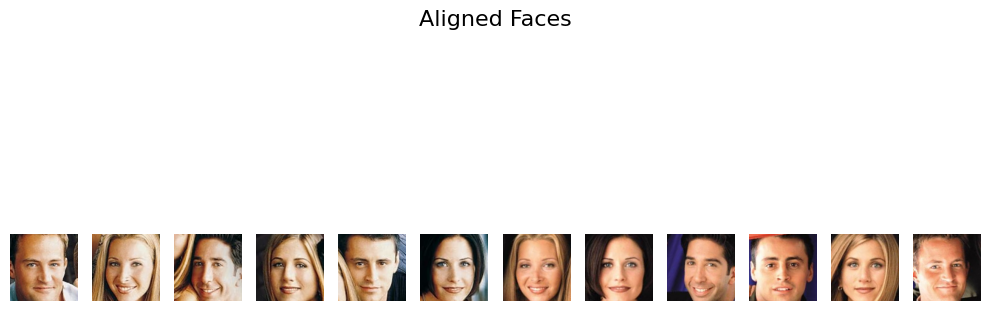

In [4]:
import matplotlib.pyplot as plt
def display_images(images, title="Images", figsize=(15, 5)):
    """
    Display a list of images in a single row using Matplotlib.

    Parameters:
    - images (list): List of images (NumPy arrays) to display.
    - title (str): Title for the plot.
    - figsize (tuple): Size of the figure.
    """
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    if num_images == 1:
        axes = [axes]  # Make it iterable for a single image
    for ax, image in zip(axes, images):
        image_rgb = image[:, :, ::-1]  # Convert BGR to RGB
        ax.imshow(image_rgb)
        ax.axis('off')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
display_images(aligned_faces, title="Aligned Faces", figsize=(10, 5))  

In [5]:
# Face recognition model name
face_rec_model_name = "arcface_mobilefacenet--112x112_quant_hailort_hailo8l_1"

# Load the face recognition model
face_rec_model = dg.load_model(
    model_name=face_rec_model_name,
    inference_host_address=inference_host_address,
    zoo_url=zoo_url,
    token=token
)

In [6]:
import numpy as np
# Process each detected face
faces_processed = []  # tuple (aligned_face, embedding)
for face in aligned_faces:
    # Extract landmarks and align the face
    embedding = np.asarray( face_rec_model(face).results[0]["data"][0]).reshape(1, -1) # shape (1,512)
    faces_processed.append((face, embedding))

In [24]:
import matplotlib.pyplot as plt
def display_pairs_similarities(images, result =0.0,title="Images", figsize=(15, 5)):
    """
    Display a list of images in a single row using Matplotlib.

    Parameters:
    - images (list): List of images (NumPy arrays) to display.
    - title (str): Title for the plot.
    - figsize (tuple): Size of the figure.
    """
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images + 1, figsize=figsize)
    if num_images == 1:
        axes = [axes]  # Make it iterable for a single image
    for ax, image in zip(axes, images):
        image_rgb = image[:, :, ::-1]  # Convert BGR to RGB
        ax.imshow(image_rgb)
        ax.axis('off')
    # Display the number as text
    axes[-1].text(0.5, 0.5, f"{round(result,2)}", fontsize=24, ha='center', va='center')
    axes[-1].set_title("similarity")
    axes[-1].axis('off')  # Turn off axes
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

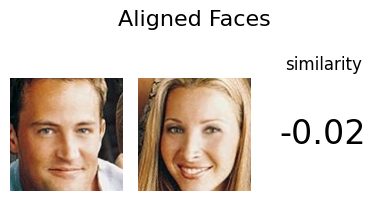

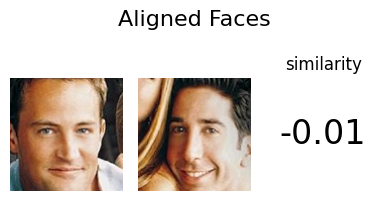

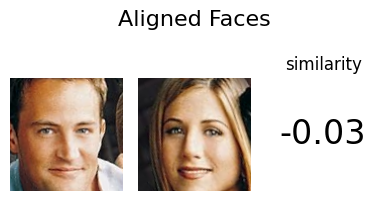

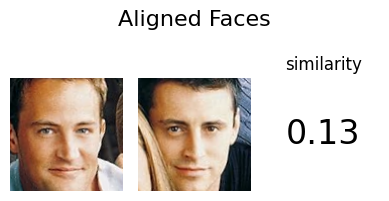

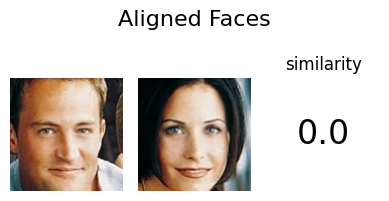

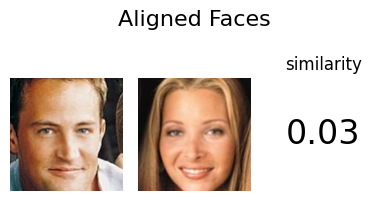

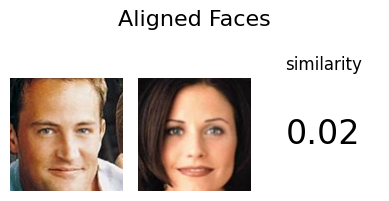

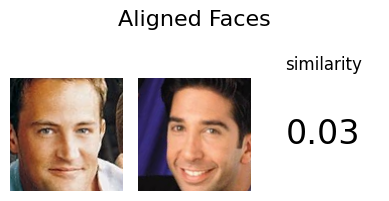

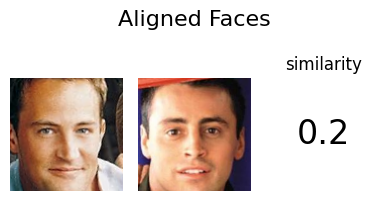

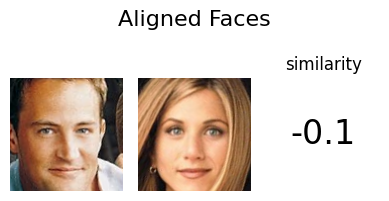

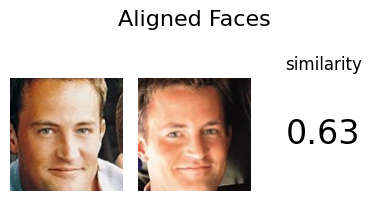

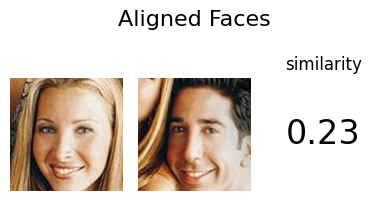

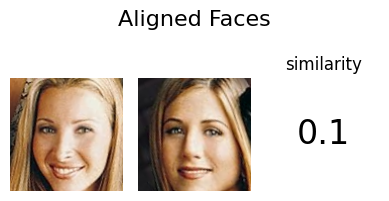

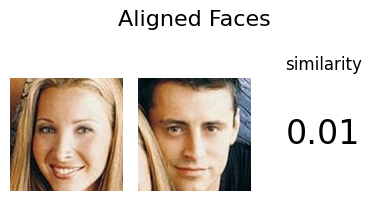

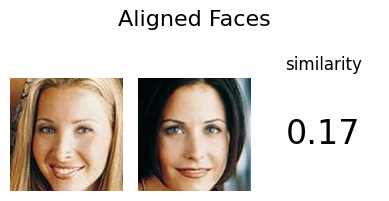

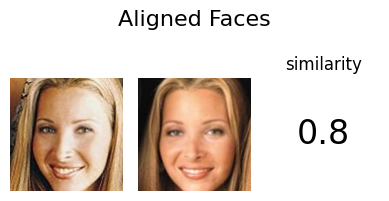

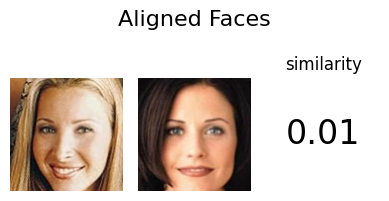

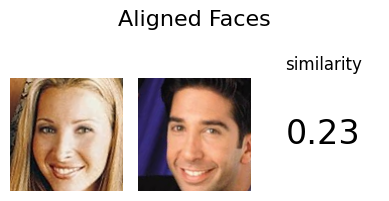

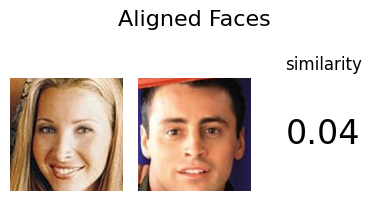

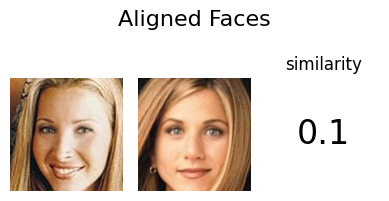

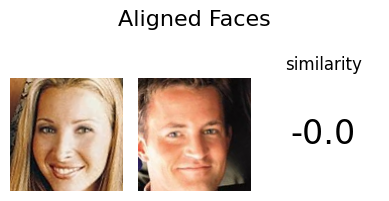

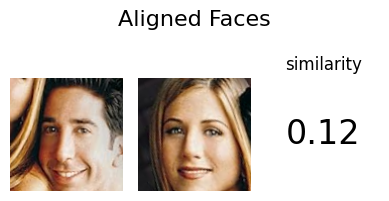

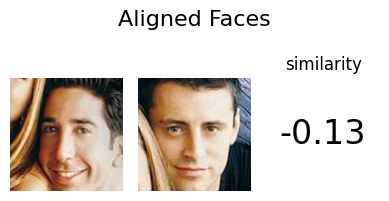

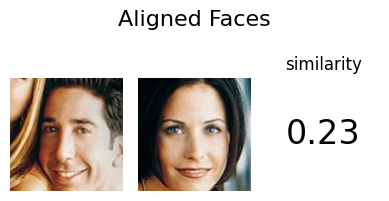

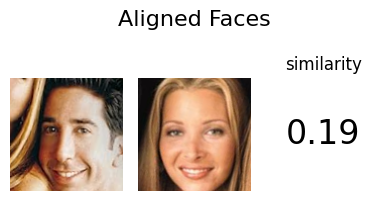

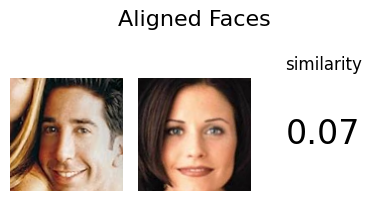

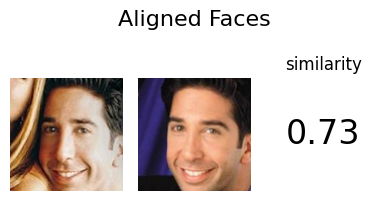

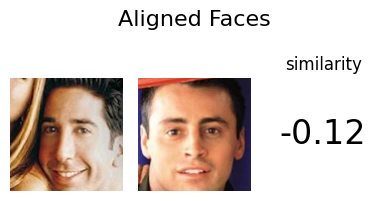

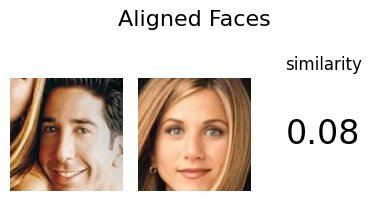

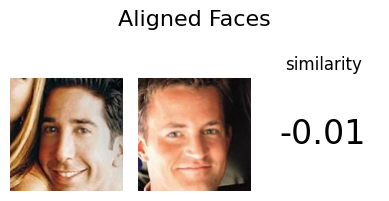

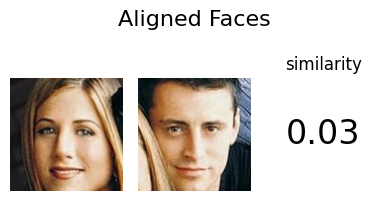

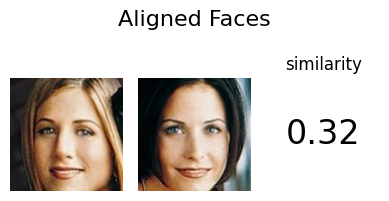

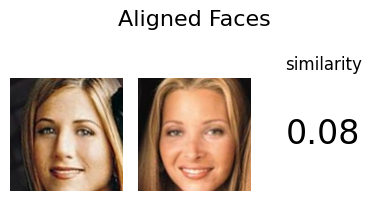

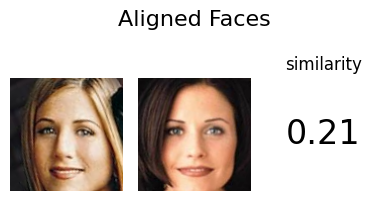

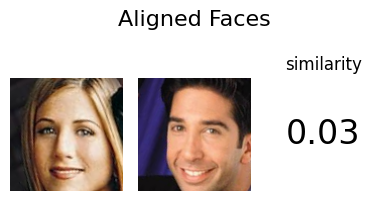

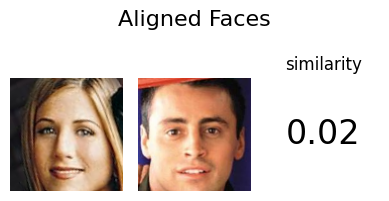

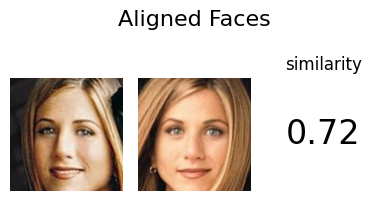

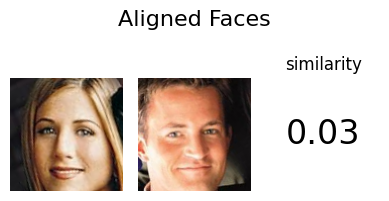

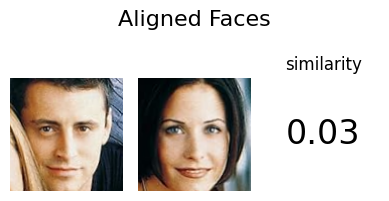

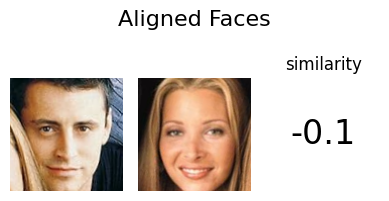

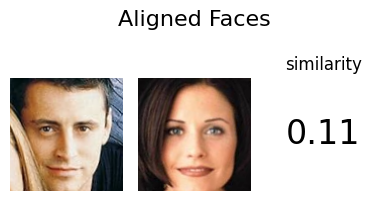

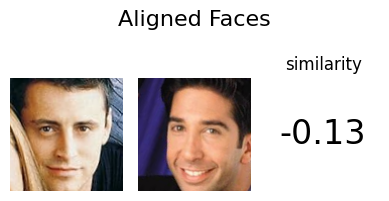

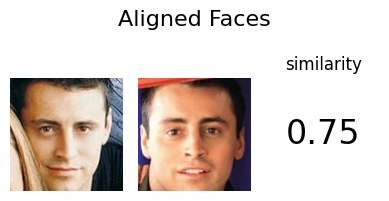

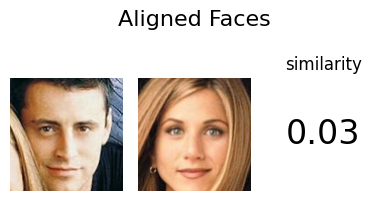

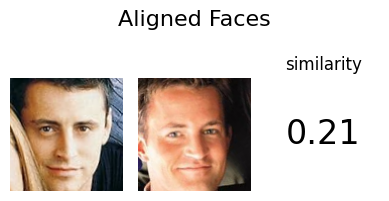

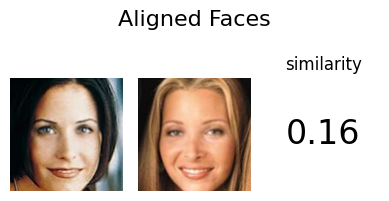

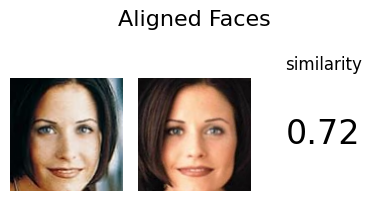

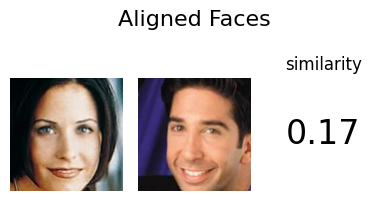

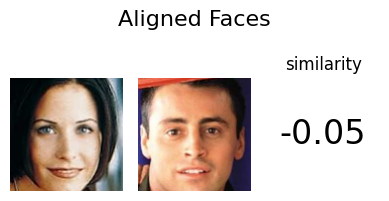

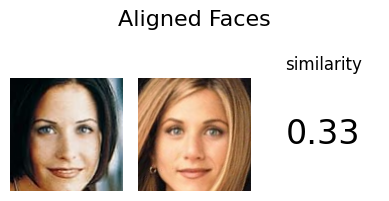

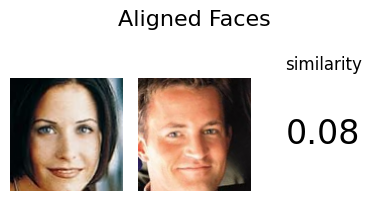

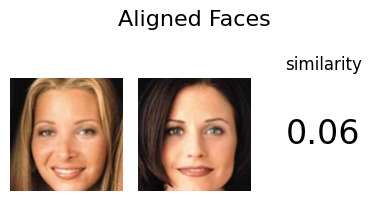

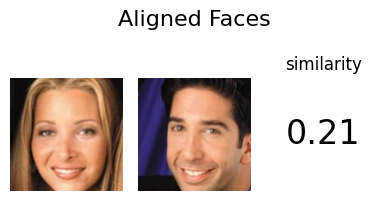

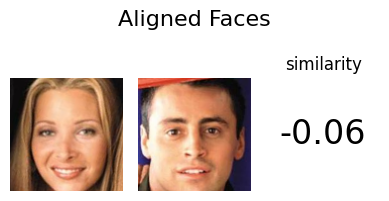

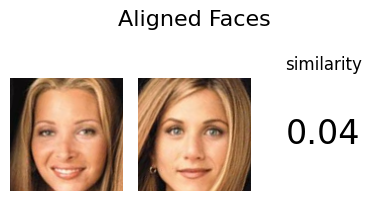

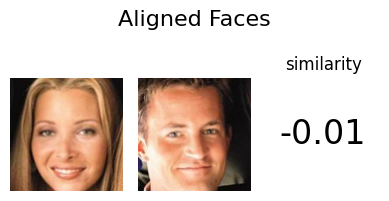

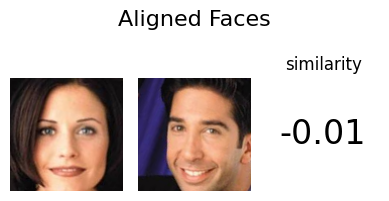

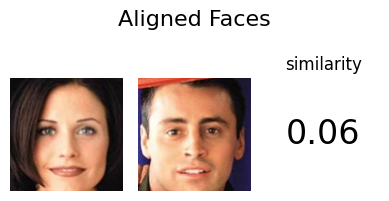

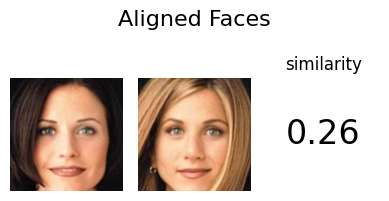

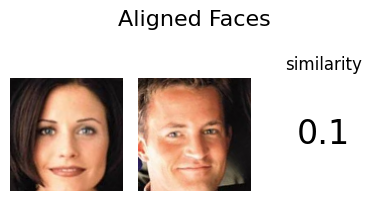

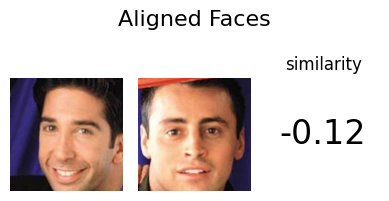

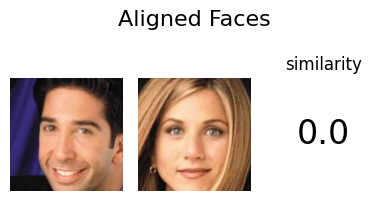

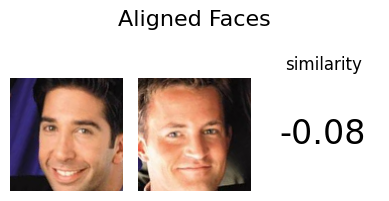

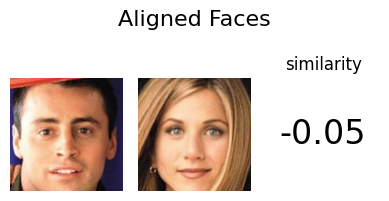

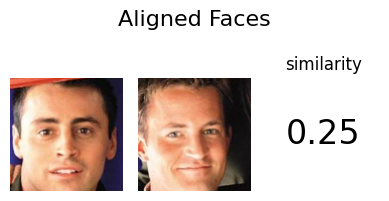

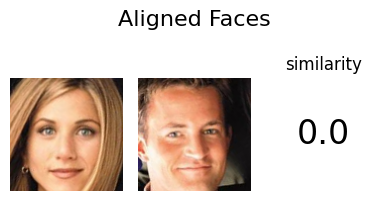

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

for face_1, face_2 in combinations(faces_processed, 2):
    similarity = cosine_similarity(face_1[1], face_2[1])[0][0]
    display_pairs_similarities([face_1[0], face_2[0]], similarity, title="Aligned Faces", figsize=(4, 2))  